In [2]:
import matplotlib.pyplot as plt
import numpy as np
import dask_geopandas as dg

# ATTENTION:
User must follow below instructions and replace the AWS access key and secret access key. This is crucial for the analysis to work.

##### Utilizing data from: https://source.coop/repositories/vida/google-microsoft-open-buildings/description

All data on Source Cooperative, are hosted on AWS S3 bucket. In order to access them, you need credentials that you can generate on Source Cooperative website. Atfer logging in, click on your name at the top right corner, and then click on your username. Then navigate to "Manage" page on the left side. At the bottom of this page you will find a section called "API Keys". If no key has been generated before, generate a new one and then copy the values for each of the following keys, and paste them in the following cell.

source.coop website: https://source.coop/

###### Source: https://github.com/github.com/HamedAlemo/vector-data-tutorial/scalable_vector_analysis.ipynb

In [2]:
AWS_ACCESS_KEY_ID = "<YOUR ACCESS KEY>"
AWS_SECRET_ACCESS_KEY = "<YOUR SECRET ACCESS KEY>"

In [3]:
import boto3
s3_client = boto3.client('s3',
                         aws_access_key_id = AWS_ACCESS_KEY_ID, 
                         aws_secret_access_key = AWS_SECRET_ACCESS_KEY,
                         endpoint_url='https://data.source.coop'
                        )

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


Local path for downloading the data

In [5]:
# If running from analysis file within the 'saved'//mounted folder and do NOT wish to save the raw data - delete the
# first local_path and uncomment (remove #) on the second one
local_path = "./data/"

# local_path ="/data/"

In [6]:
country_code = "HTI" 
country_epsg = 32618

# other countries and their epsg:  Ruwanda - RWA - 32736, Jamaica - JAM - 32618

In [7]:
import utils as ut

In [8]:
bldg_ddf = ut.get_google_microsoft_bldgs(country_code, s3_client, local_path, blocksize = "16M") #256M is regular

File already exists locally. No download needed.


In [9]:
bldg_ddf.head(5)

,boundary_id,bf_source,confidence,area_in_meters,s2_id,country_iso,geohash,geometry,bbox
0,46,google,0.8859,72.1027,-8358680908399640576,HTI,d7hyzef7,"POLYGON ((-71.73728 18.08274, -71.7373 18.0828...","{'xmin': -71.737376442709, 'ymin': 18.08271951..."
1,46,google,0.7450,15.3979,-8358680908399640576,HTI,d7hyzs16,"POLYGON ((-71.73892 18.08389, -71.73891 18.083...","{'xmin': -71.7389615903488, 'ymin': 18.0838892..."
2,46,google,0.6963,19.8751,-8358680908399640576,HTI,d7hyzs16,"POLYGON ((-71.73891 18.08392, -71.73891 18.083...","{'xmin': -71.7389593761971, 'ymin': 18.0839181..."
3,46,google,0.7250,34.8499,-8358680908399640576,HTI,d7hyzs4r,"POLYGON ((-71.73744 18.08483, -71.73745 18.084...","{'xmin': -71.7375028683806, 'ymin': 18.0848225..."
4,46,google,0.6822,20.9196,-8358680908399640576,HTI,d7hyzs98,"POLYGON ((-71.73847 18.08624, -71.73847 18.086...","{'xmin': -71.7385125967971, 'ymin': 18.0862357..."


In [62]:
bldg_ddf.count().compute()

boundary_id       4274765
bf_source         4274765
confidence        3971240
area_in_meters    4274765
s2_id             4274765
country_iso       4274765
geohash           4274765
geometry          4274765
bbox              4274765
dtype: int64

### Task 1. Plot the histogram of the area of all buildings provided by Microsoft as the source.

In [10]:
bldg_ddf_microsoft = bldg_ddf[bldg_ddf['bf_source'] == 'microsoft']

In [11]:
bldg_ddf_microsoft.shape[0].compute()

303525

In [12]:
binLength = len(bldg_ddf_microsoft) // 3000

#### Regular output (minus the outlier, so data is easier to see)

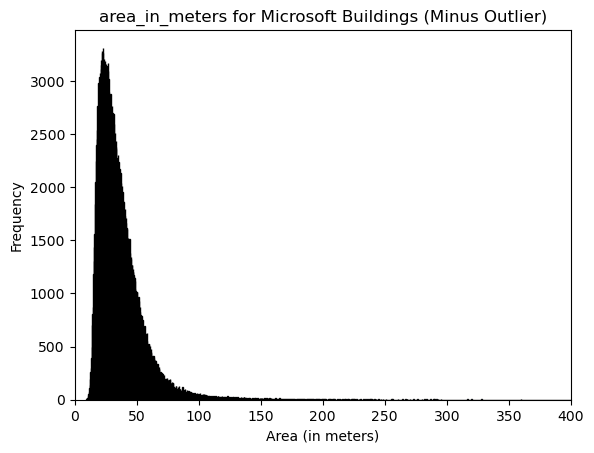

In [21]:
bldg_ddf_microsoft_sorted = bldg_ddf_microsoft.sort_values(by='area_in_meters', ascending=False).compute()
bldg_ddf_microsoft_filtered = bldg_ddf_microsoft_sorted.drop(bldg_ddf_microsoft_sorted.index[0])

plt.hist(bldg_ddf_microsoft_filtered['area_in_meters'], bins = 5000, edgecolor='black')
plt.xlim([0, 400])
plt.xlabel('Area (in meters)')
plt.ylabel('Frequency')
plt.title('area_in_meters for Microsoft Buildings (Minus Outlier)')
plt.show()

#### To handle the skew (including the outlier)

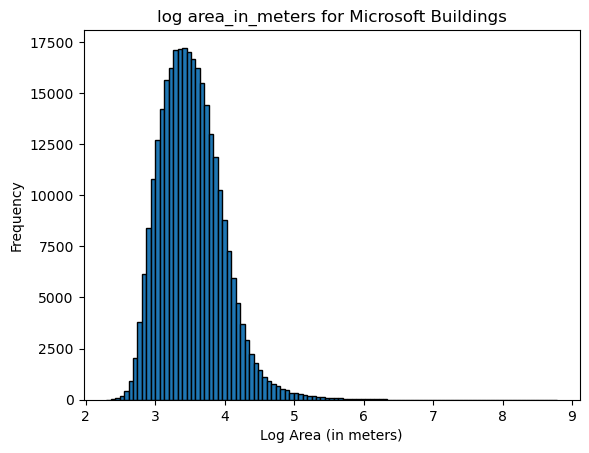

In [22]:
bldg_ddf_microsoft['new_AreaInMeters'] = np.log1p(bldg_ddf_microsoft['area_in_meters'])

plt.hist(bldg_ddf_microsoft['new_AreaInMeters'], bins = binLength, edgecolor='black')
plt.xlabel('Log Area (in meters)')
plt.ylabel('Frequency')
plt.title('log area_in_meters for Microsoft Buildings')
plt.show()

### Task 2. Count the number of building footprints that intersect with each other.


In [11]:
rows = bldg_ddf.shape[0].compute()
print(f"The entire dataframe has: {rows} rows")

The entire dataframe has: 4274765 rows


In [12]:
bldg_ddf_intersections = dg.sjoin(bldg_ddf, bldg_ddf, how='inner', predicate='intersects')
count = (bldg_ddf_intersections.shape[0].compute()) - rows   #minus rows will subtract all self-counts
print(f"Total number of building footprints that intersect with each other: {count}")

Total number of building footprints that intersect with each other: 1988984


### Task 3. From the intersecting building footprints, calculate how many:

- Google building footprints intersect another Google building footprint

- Microsoft building footprints intersect another Microsoft building footprint

- Google building footprints intersect a Microsoft building footprint

#### Remove the repeated self-count intersections (USED ONLY FOR DATA VERIFICATION)

In [13]:
bldg_ddf_intersections = bldg_ddf_intersections.loc[bldg_ddf_intersections['index_right'] != bldg_ddf_intersections.index]

In [16]:
bldg_ddf_intersections.shape[0].compute()

2024-11-25 21:02:25,680 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.86 GiB -- Worker memory limit: 5.84 GiB


1988984

#### Grab the google rows:

In [11]:
bldg_ddf_google = bldg_ddf[bldg_ddf['bf_source'] == 'google']

#### Already got the microsoft rows:

In [ ]:
bldg_ddf_microsoft

### Calculate the number of Google building footprints intersecting another Google building footprint

In [14]:
# do a join for google on google,
# remove repeats

# if had enough RAM can try (my set-up only has 12):
# bldg_ddf_google_intersections = dg.sjoin(bldg_ddf_google, bldg_ddf_google, how='inner', predicate='intersects')
# bldg_ddf_intersections = bldg_ddf_intersections.loc[bldg_ddf_intersections['index_right'] != bldg_ddf_intersections.index]
# count = bldg_ddf_intersections.shape[0].compute()

# If low on ram:
bldg_ddf_google_intersections = dg.sjoin(bldg_ddf_google, bldg_ddf_google, how='inner', predicate='intersects')
rows = bldg_ddf_google.shape[0].compute()
count = (bldg_ddf_google_intersections.shape[0].compute()) - rows   #minus rows will subtract all self-counts

     
print(f"Total number of Google building footprints that intersect with another Google building footprint: {count}")

Total number of Google building footprints that intersect with another Google building footprint: 1987914


### Calculate the number of Microsoft building footprints intersecting another Microsoft building footprint

In [12]:
# do a join for microsoft on microsoft
# remove repeats

# If low on ram:
bldg_ddf_microsoft_intersections = dg.sjoin(bldg_ddf_microsoft, bldg_ddf_microsoft, how='inner', predicate='intersects')
rows = bldg_ddf_microsoft.shape[0].compute()
count = (bldg_ddf_microsoft_intersections.shape[0].compute()) - rows   #minus rows will subtract all self-counts

     
print(f"Total number of Microsoft building footprints that intersect with another Microsoft building footprint: {count}")

Total number of Microsoft building footprints that intersect with another Microsoft building footprint: 1070


### Calculate the number of Google building footprints intersection a Microsoft building footprint

In [13]:
# do a join for google on microsoft

# If low on ram:
bldg_ddf_google_microsoft_intersections = dg.sjoin(bldg_ddf_google, bldg_ddf_microsoft, how='inner', predicate='intersects')
count = (bldg_ddf_google_microsoft_intersections.shape[0].compute())

     
print(f"Total number of Google building footprints that intersect with a Microsoft building footprint: {count}")

Total number of Google building footprints that intersect with a Microsoft building footprint: 0
